AMV Historical Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
df = pd.read_csv('AMV Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,04/17/2024,"3,200.0","3,300.0","3,300.0","3,000.0",2.53M,-3.03%
1,04/16/2024,"3,300.0","3,300.0","3,400.0","3,100.0",1.31M,0.00%
2,04/15/2024,"3,300.0","3,500.0","3,600.0","3,300.0",1.28M,-5.71%
3,04/12/2024,"3,500.0","3,500.0","3,600.0","3,500.0",840.38K,0.00%
4,04/11/2024,"3,500.0","3,500.0","3,600.0","3,500.0",587.87K,0.00%
5,04/10/2024,"3,500.0","3,500.0","3,600.0","3,500.0",324.14K,0.00%
6,04/09/2024,"3,500.0","3,600.0","3,700.0","3,400.0",2.18M,-2.78%
7,04/08/2024,"3,600.0","3,600.0","3,700.0","3,600.0",703.91K,0.00%
8,04/05/2024,"3,600.0","3,700.0","3,700.0","3,500.0",3.40M,-5.26%
9,04/04/2024,"3,800.0","3,800.0","3,900.0","3,700.0",867.30K,0.00%


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [4]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,17072.0,17071.7,17117.0,16936.5,181.74K,-0.26%
2019-01-03,16982.0,17026.6,17027.0,16215.8,259.31K,-0.53%
2019-01-04,16666.0,16666.3,16801.0,16576.2,86.63K,-1.86%
2019-01-07,16171.0,16576.2,16576.0,16080.7,102.90K,-2.97%
2019-01-08,16171.0,16260.9,16261.0,16080.7,33.59K,0.00%
...,...,...,...,...,...,...
2024-04-11,3500.0,3500.0,3600.0,3500.0,587.87K,0.00%
2024-04-12,3500.0,3500.0,3600.0,3500.0,840.38K,0.00%
2024-04-15,3300.0,3500.0,3600.0,3300.0,1.28M,-5.71%


In [5]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [7]:
# Split data into training and testing sets
train_size = int(0.7 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [8]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [9]:
# Create training and testing datasets
time_step = 100
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, ytest = create_dataset(test_features, test_target, time_step)

In [10]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [11]:
# Build and train RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1617 - val_loss: 0.0013
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 0.0010


In [12]:
# Extract features from RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [13]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_rnn, label=y_train)
test_data_lgb = lgb.Dataset(test_features_rnn, label=ytest, reference=train_data_lgb)

In [14]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [15]:
# Train LightGBM model with early stopping
evals_result = {}
lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=100,
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.record_evaluation(evals_result)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 824, number of used features: 1
[LightGBM] [Info] Start training from score 0.519758
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [16]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_rnn, num_iteration=lgb_model.best_iteration)

In [17]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [18]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
msle = mean_squared_log_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)

In [19]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Root Mean Squared Error (RMSE): 0.17442451903770823
Mean Absolute Percentage Error (MAPE): 291.51930801220686%
Mean Squared Logarithmic Error (MSLE): 0.02300947505212687
Mean Squared Error (MSE): 0.03042391284153584
Mean Absolute Error (MAE): 0.17277182830295074


In [20]:
# Prepare initial data for predicting next 30 days
initial_data = scaled_features[-time_step:].reshape(1, time_step, scaled_features.shape[1])

In [21]:
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []

    for _ in range(30):
        # Predict features using RNN
        rnn_features = rnn_model.predict(initial_data)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the initial data with the new prediction
        initial_data = np.roll(initial_data, -1, axis=1)
        initial_data[:, -1, -1] = next_close[0]

    return predictions

In [22]:
# Predict next 30 days
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

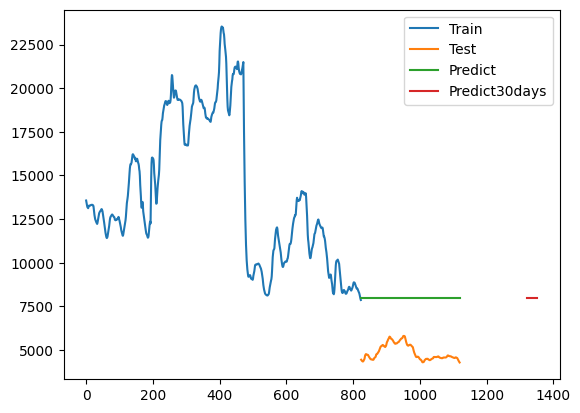

In [24]:
import matplotlib.pyplot as plt

# Plotting train data
train_data_index = pd.RangeIndex(start=0, stop=len(train_features_rnn), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

# Plotting test data
test_data_index = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(test_features_rnn), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=len(df), stop=len(df) + len(next_30_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()

DHT Historical Data

In [25]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [26]:
df = pd.read_csv('DHT Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,04/17/2024,"26,700.0","26,600.0","27,200.0","26,500.0",104.91K,1.14%
1,04/16/2024,"26,400.0","26,300.0","26,800.0","26,100.0",69.69K,-1.49%
2,04/15/2024,"26,800.0","26,900.0","27,400.0","26,500.0",51.17K,-0.37%
3,04/12/2024,"26,900.0","26,800.0","27,200.0","26,500.0",29.56K,1.51%
4,04/11/2024,"26,500.0","26,500.0","27,000.0","26,100.0",56.40K,-0.38%
5,04/10/2024,"26,600.0","26,800.0","26,900.0","26,500.0",27.07K,-0.37%
6,04/09/2024,"26,700.0","26,300.0","27,200.0","26,300.0",45.80K,-0.74%
7,04/08/2024,"26,900.0","26,800.0","27,100.0","26,500.0",23.60K,0.37%
8,04/05/2024,"26,800.0","27,200.0","27,300.0","24,600.0",173.17K,-1.83%
9,04/04/2024,"27,300.0","27,300.0","27,700.0","26,800.0",155.52K,-0.36%


In [27]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)

In [28]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-03,11842.2,11224.9,11982.5,11224.9,40.97K,-0.24%
2019-01-04,11393.2,12207.0,12207.0,11393.2,0.92K,-3.79%
2019-01-07,11421.3,11786.1,11786.1,11252.9,44.97K,0.25%
2019-01-08,11421.3,11645.8,11645.8,11224.9,10.47K,0.00%
2019-01-09,11421.3,11758.0,11758.0,11224.9,8.62K,0.00%
...,...,...,...,...,...,...
2024-04-11,26500.0,26500.0,27000.0,26100.0,56.40K,-0.38%
2024-04-12,26900.0,26800.0,27200.0,26500.0,29.56K,1.51%
2024-04-15,26800.0,26900.0,27400.0,26500.0,51.17K,-0.37%


In [29]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [30]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [31]:
# Split data into training and testing sets
train_size = int(0.7 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [32]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [33]:
# Create training and testing datasets
time_step = 100
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, ytest = create_dataset(test_features, test_target, time_step)

In [34]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [35]:
# Build and train RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0464 - val_loss: 8.5732e-05
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015 - val_loss: 1.3749e-04
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.2111e-04 - val_loss: 2.0044e-04
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.5226e-04 - val_loss: 2.2151e-04
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4116e-04 - val_loss: 1.8934e-04
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.2602e-04 - val_loss: 2.9149e-04
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5535e-04 - val_loss: 1.0202e-04
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.0655e-04 - val_loss: 5.3437e-05
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0295e-04 - val_loss: 1.4853e-04
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8980e-04 - val_loss: 2.7444e-04


In [36]:
# Extract features from RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [37]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_rnn, label=y_train)
test_data_lgb = lgb.Dataset(test_features_rnn, label=ytest, reference=train_data_lgb)

In [38]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [39]:
# Train LightGBM model with early stopping
evals_result = {}
lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=100,
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.record_evaluation(evals_result)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 822, number of used features: 1
[LightGBM] [Info] Start training from score 0.317970
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [40]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_rnn, num_iteration=lgb_model.best_iteration)

In [41]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [42]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
msle = mean_squared_log_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)

In [43]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Root Mean Squared Error (RMSE): 0.25170499176174305
Mean Absolute Percentage Error (MAPE): 45.28845636791226%
Mean Squared Logarithmic Error (MSLE): 0.02325281281408567
Mean Squared Error (MSE): 0.06335540287777913
Mean Absolute Error (MAE): 0.1989427614377937


In [44]:
# Prepare initial data for predicting next 30 days
initial_data = scaled_features[-time_step:]

In [45]:
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []
    current_sequence = initial_data.reshape(1, time_step, initial_data.shape[1])

    for _ in range(30):
        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        current_sequence[:, :-1, :] = current_sequence[:, 1:, :]
        current_sequence[:, -1, -1] = next_close[0]

    return predictions

In [46]:
# Predict next 30 days
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

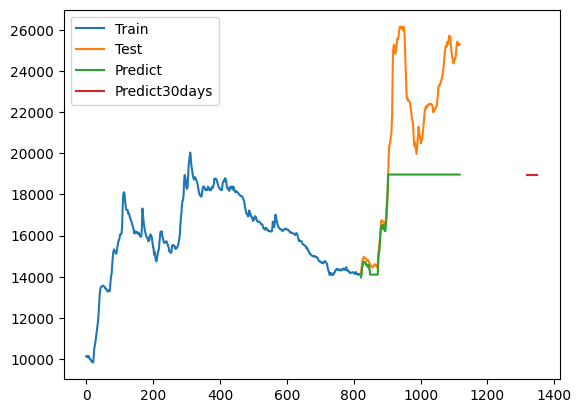

In [47]:
import matplotlib.pyplot as plt

# Plotting train data
train_data_index = pd.RangeIndex(start=0, stop=len(train_features_rnn), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

# Plotting test data
test_data_index = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(test_features_rnn), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=len(df), stop=len(df) + len(next_30_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()

DP3 Historical Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
df = pd.read_csv('DP3 Historical Data.csv')
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,04/17/2024,"68,000","68,000","68,300","68,000",8.91K,0.00%
1,04/16/2024,"68,000","68,600","68,600","66,900",10.76K,-0.73%
2,04/15/2024,"68,500","69,300","69,300","68,000",14.22K,-1.15%
3,04/12/2024,"69,300","68,900","69,300","68,900",3.01K,0.58%
4,04/11/2024,"68,900","69,500","69,500","68,200",5.36K,-0.86%
5,04/10/2024,"69,500","69,500","69,500","69,500",2.30K,0.58%
6,04/09/2024,"69,100","70,500","70,500","69,100",2.47K,-1.14%
7,04/08/2024,"69,900","70,000","70,000","68,000",6.30K,-0.14%
8,04/05/2024,"70,000","70,000","70,000","67,500",10.25K,0.00%
9,04/04/2024,"70,000","70,400","70,700","70,000",2.80K,-0.57%


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date in ascending order
df = df.sort_values('Date')

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df = df.replace(',', '', regex=True)


In [4]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,85500,85000,92000,85000,12.70K,0.59%
2019-01-03,86500,85100,87900,85100,6.40K,1.17%
2019-01-04,87900,86700,88000,86600,4.87K,1.62%
2019-01-07,87900,86700,87900,86700,5.10K,0.00%
2019-01-08,91800,88000,92000,88000,19.40K,4.44%
...,...,...,...,...,...,...
2024-04-11,68900,69500,69500,68200,5.36K,-0.86%
2024-04-12,69300,68900,69300,68900,3.01K,0.58%
2024-04-15,68500,69300,69300,68000,14.22K,-1.15%


In [5]:
# Select features and target
features = df[['Open', 'High', 'Low', 'Price']].values
target = df['Price'].values

In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(np.array(target).reshape(-1, 1))

In [7]:
# Split data into training and testing sets
train_size = int(0.7 * len(scaled_target))
test_size = len(scaled_target) - train_size

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]
test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

In [8]:
# Function to create dataset matrix
def create_dataset(features, target, time_step=1):
    dataX, dataY = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step)]
        dataX.append(a)
        dataY.append(target[i + time_step])
    return np.array(dataX), np.array(dataY)

In [9]:
# Create training and testing datasets
time_step = 100
X_train, y_train = create_dataset(train_features, train_target, time_step)
X_test, ytest = create_dataset(test_features, test_target, time_step)

In [10]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [11]:
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1183 - val_loss: 0.0044
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 7.6152e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 7.4443e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 8.5737e-04
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 9.2834e-04
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.3479e-04 - val_loss: 7.9813e-04


In [12]:
# Extract features from RNN
train_features_rnn = rnn_model.predict(X_train)
test_features_rnn = rnn_model.predict(X_test)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [13]:
# Prepare data for LightGBM
train_data_lgb = lgb.Dataset(train_features_rnn, label=y_train)
test_data_lgb = lgb.Dataset(test_features_rnn, label=ytest, reference=train_data_lgb)

In [14]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [15]:
# Train LightGBM model with early stopping
evals_result = {}
lgb_model = lgb.train(
    params,
    train_data_lgb,
    num_boost_round=100,
    valid_sets=[train_data_lgb, test_data_lgb],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.record_evaluation(evals_result)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 701, number of used features: 1
[LightGBM] [Info] Start training from score 0.328234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [16]:
# Predict using LightGBM
y_pred = lgb_model.predict(test_features_rnn, num_iteration=lgb_model.best_iteration)

In [17]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [18]:
# Calculate evaluation metrics
rmse = root_mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
msle = mean_squared_log_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)


In [19]:
# Print evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.08429861646094844
Mean Absolute Percentage Error (MAPE): 186.63383453498483%
Mean Squared Logarithmic Error (MSLE): 0.0033608460361502376
Mean Squared Error (MSE): 0.007106256737230086
Mean Absolute Error (MAE): 0.035679993042111925


In [20]:
# Prepare initial data for predicting next 30 days
initial_data = scaled_features[-time_step:]

In [21]:
def predict_next_30_days(rnn_model, lgb_model, initial_data, time_step=100):
    predictions = []
    current_sequence = initial_data.reshape(1, time_step, initial_data.shape[1])

    for _ in range(30):
        # Predict features using RNN
        rnn_features = rnn_model.predict(current_sequence)

        # Predict the next day's closing price using LightGBM
        next_close = lgb_model.predict(rnn_features)

        # Append the prediction
        predictions.append(next_close[0])

        # Update the sequence with the new prediction
        current_sequence[:, :-1, :] = current_sequence[:, 1:, :]
        current_sequence[:, -1, -1] = next_close[0]

    return predictions

In [22]:
# Predict next 30 days
next_30_days_predictions = predict_next_30_days(rnn_model, lgb_model, initial_data)
print("Dự đoán giá đóng cửa cho 30 ngày tiếp theo:", next_30_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

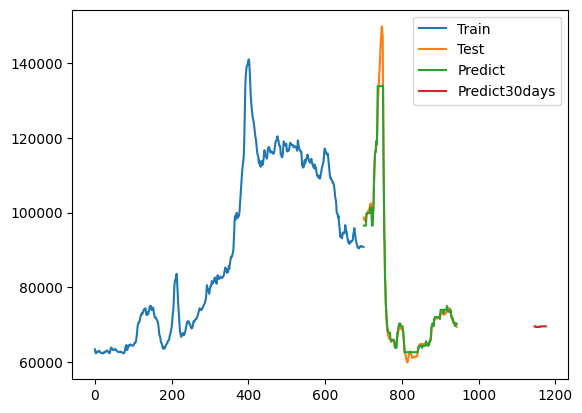

In [23]:
import matplotlib.pyplot as plt

# Plotting train data
train_data_index = pd.RangeIndex(start=0, stop=len(train_features_rnn), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_features_rnn), label='Train')

# Plotting test data
test_data_index = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(test_features_rnn), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_features_rnn), label='Test')

# Adjusting y_pred to have correct shape and length
test_data_index_pred = pd.RangeIndex(start=len(train_features_rnn), stop=len(train_features_rnn) + len(y_pred), step=1)
plt.plot(test_data_index_pred, scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)), label='Predict')

# Adjusting next_30_days_predictions to have correct shape and length
predict_data_index = pd.RangeIndex(start=len(df), stop=len(df) + len(next_30_days_predictions), step=1)
plt.plot(predict_data_index, scaler.inverse_transform(np.array(next_30_days_predictions).reshape(-1, 1)), label='Predict30days')

plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()